In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def recorte_adaptativo(img):
    # Convertir a escala de grises
    if len(img.shape) == 3:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Umbralización (Otsu)
    _, thresh = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    # Asegurar fondo blanco (huella negra)
    white_ratio = np.sum(thresh == 255) / thresh.size
    black_ratio = np.sum(thresh == 0) / thresh.size
    if black_ratio > white_ratio:
        thresh = cv.bitwise_not(thresh)

    # === Detectar contornos para encontrar el ROI ===
    # Invertimos: huella blanca sobre fondo negro
    inverted = cv.bitwise_not(thresh)

    # Encontrar contornos externos
    contours, _ = cv.findContours(inverted, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        print("❌ No se detectaron contornos.")
        return img, thresh

    # Tomar el contorno más grande (la huella)
    largest_contour = max(contours, key=cv.contourArea)
    x, y, w, h = cv.boundingRect(largest_contour)

    # Margen opcional para no cortar tan justo
    margen = 10
    y1 = max(y - margen, 0)
    y2 = min(y + h + margen, img.shape[0])
    x1 = max(x - margen, 0)
    x2 = min(x + w + margen, img.shape[1])

    cropped = img[y1:y2, x1:x2]

    # También devolvemos el rectángulo y las sumas (opcional)
    sum_rows = np.sum(thresh, axis=1)
    sum_cols = np.sum(thresh, axis=0)

    return cropped, thresh, sum_rows, sum_cols, (x1, y1, x2, y2)

(768, 832) (768, 832) (224, 224) (224, 210)


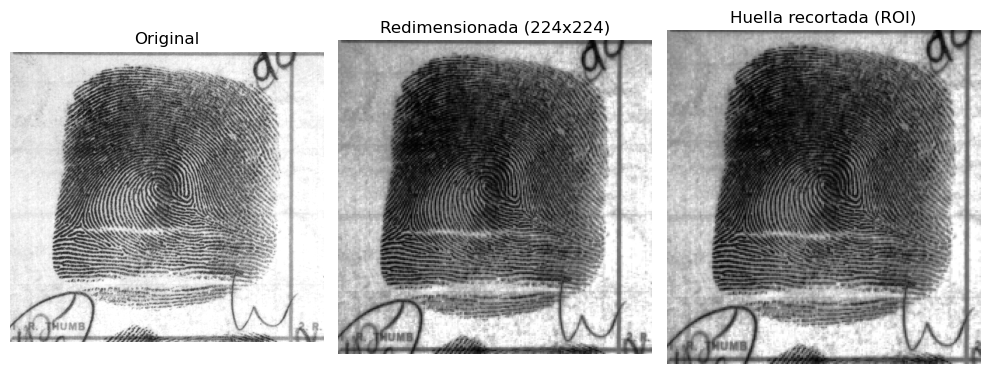

(768, 832) (768, 832) (224, 224) (224, 180)


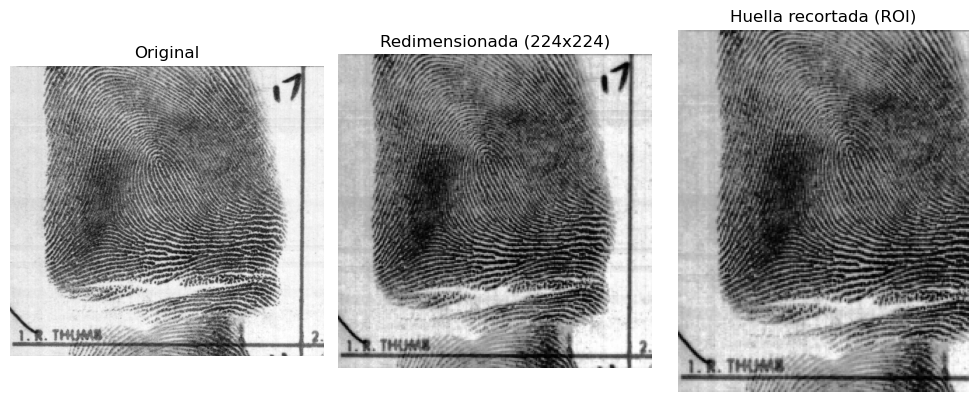

(768, 832) (768, 832) (224, 224) (224, 221)


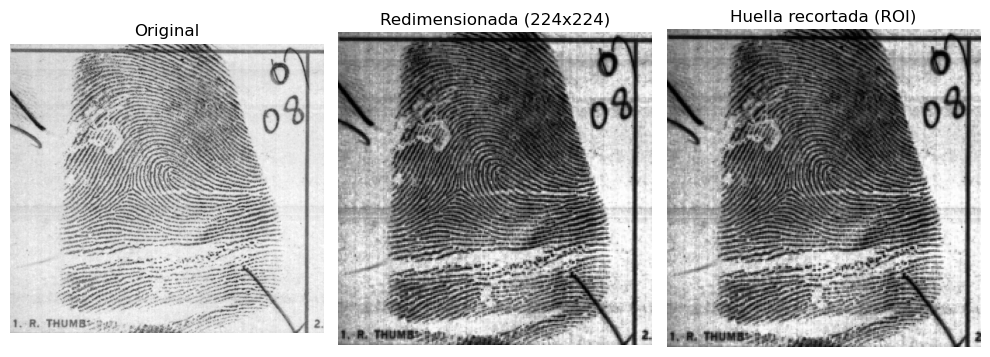

(768, 832) (768, 832) (224, 224) (224, 221)


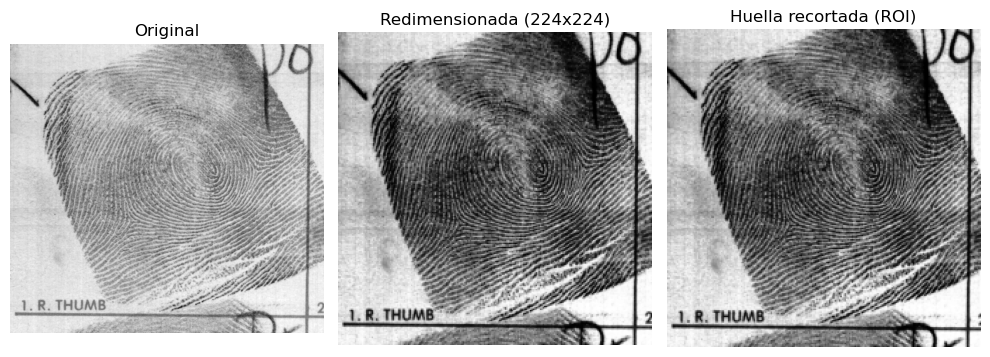

(768, 832) (768, 832) (224, 224) (224, 218)


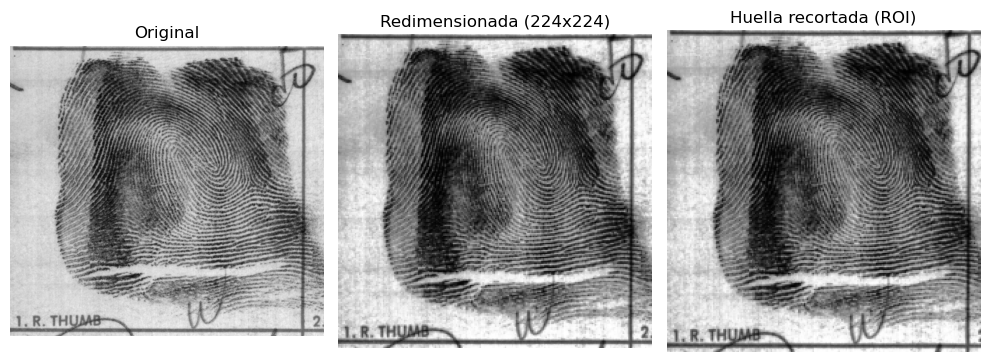

(768, 832) (768, 832) (224, 224) (224, 220)


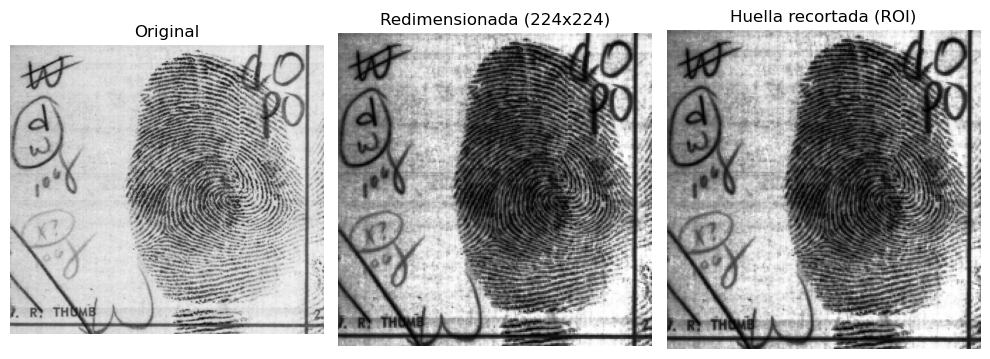

(768, 832) (768, 832) (224, 224) (224, 224)


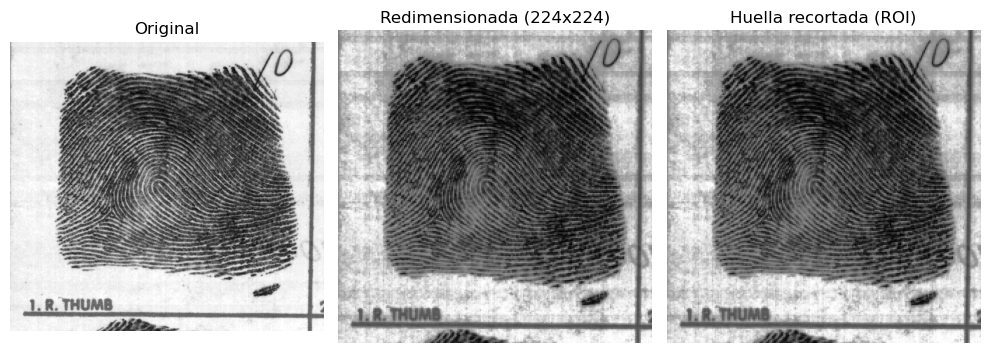

(768, 832) (768, 832) (224, 224) (224, 219)


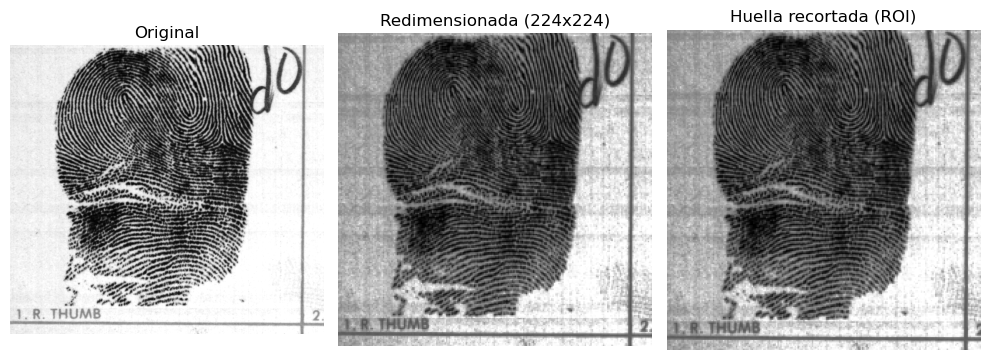

(768, 832) (768, 832) (224, 224) (224, 224)


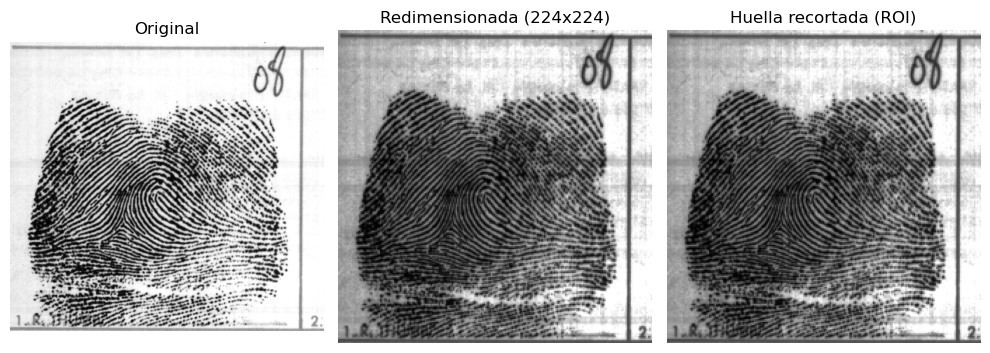

(768, 832) (768, 832) (224, 224) (224, 224)


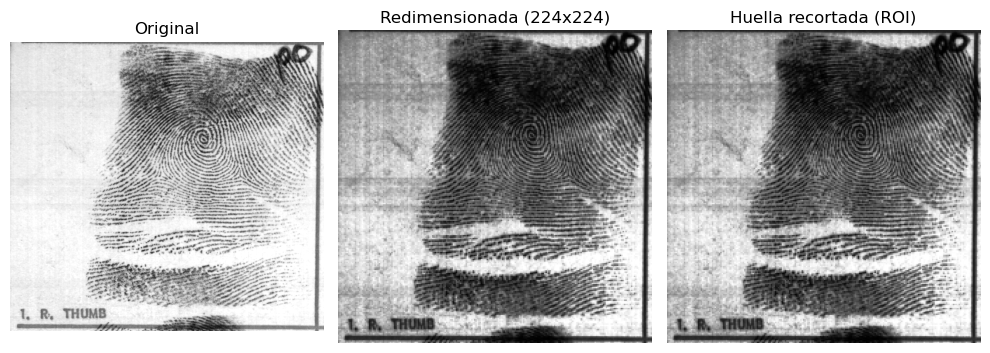

In [7]:
import os
import cv2 as cv
import numpy as np

#ENTRADA Y PREPROCESADO

sample_path = "../BaseDatosNISTsd09_pr"
folders = sorted(os.listdir(sample_path))

for folder in folders:
    dir_path = os.path.join(sample_path, folder)
    files = sorted(os.listdir(dir_path))

    if len(files) == 0:
        continue
    #Cargamos la ruta de la imagen
    ruta_f = os.path.join(dir_path, files[0])
    ruta_s = os.path.join(dir_path, files[1])
    img = cv.imread(ruta_f, cv.IMREAD_GRAYSCALE) #Escala Gris
    if img is None:
        continue

    img_eq = cv.equalizeHist(img) #Aplicamos la normalización por ecualización 
    img_resize = cv.resize(img_eq, (224, 224), interpolation=cv.INTER_AREA) #Aplicamos el tamaño fijo de 224x224 px
    
    recortada, umbralizada, sum_rows, sum_cols, bbox = recorte_adaptativo(img_resize) #Funcion para el recorte y eliminación de fondo de la huella 
    
    print(img.shape, img_eq.shape, img_resize.shape, recortada.shape)
    
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(img_resize, cmap='gray')
    plt.title("Redimensionada (224x224)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(recortada, cmap='gray')
    plt.title("Huella recortada (ROI)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

De momento solo hemo, implementado la arquitectura de la red convolucional basandonos en un ejemplo de un ejercicio que hicimos en la asignatura de aprendizaje automático II, ahora tenemos que adaptar el problema para que se adapte anuestro problema en concreto

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Definimos las transformaciones para normalizar los datos
# Las imágenes originales están en escala de grises con valores entre 0.0 y 1.0
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertimos imágenes a Tensores
    transforms.Normalize((0.5,), (0.5,))  # Normalizamos con media 0.5 y desviación estándar 0.5
])

# Cargamos el dataset MNIST
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader para los conjuntos de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)  # Entrada: 1 canal, Salida: 16 canales, kernel de 5x5
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Max pooling con un kernel de 2x2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)  # Entrada: 16 canales, Salida: 32 canales
        self.fc1 = nn.Linear(32 * 7 * 7, 120)  # Imágenes reducidas a 7x7 después del pooling
        self.fc2 = nn.Linear(120, 10)  # 10 clases de salida para MNIST

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)  # Aplanamos el tensor para la capa lineal
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
import torch.optim as optim

model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()  # Limpiamos los gradientes
        outputs = model(images)  # Pasamos las imágenes por la red
        loss = criterion(outputs, labels)  # Calculamos la pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualizamos los pesos
        
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

In [ ]:
correct = 0
total = 0
with torch.no_grad():  # No necesitamos calcular gradientes para la evaluación
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the 10000 test images: {100 * correct / total}%')